In [1]:
import time
import torch.backends.cudnn as cudnn
from torch import nn
from torch.utils.data import DataLoader
from models import Generator, Discriminator, TruncatedVGG19
from datasets import SRDataset
from utils import *
from utils_.dataloader import Dataset as dataset
import utils_.helper_functions as helper_functions
from utils_.losses import calculate_metrics
import torch
from datetime import datetime
import wandb
import numpy as np
import matplotlib.pyplot as plt
import time

from pynvml import *

C:\Users\accou\anaconda3\envs\geo_env3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!/bin/bash -l
#SBATCH --chdir=/share/projects/erasmus/sesure/SRGAN_experiments/w_0.001
#SBATCH --gres=gpu:1
#SBATCH --cpus-per-task 4
#SBATCH --partition shortrun
#SBATCH --output output_SRCNN.out
#SBATCH --time=2-00:00:00


#setcuda 11.0
#conda activate python37

### OPTIONAL, copy data project data ###

#python SRGAN_GH_sat.py

In [3]:
# Data parameters
data_folder = './'  # folder with JSON data files
crop_size = 300  # crop size of target HR images
scaling_factor = 4  # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor

# Generator parameters
large_kernel_size_g = 9  # kernel size of the first and last convolutions which transform the inputs and outputs
small_kernel_size_g = 3  # kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
n_channels_g = 64  # number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
n_blocks_g = 16  # number of residual blocks
srresnet_checkpoint = None  # filepath of the trained SRResNet checkpoint used for initialization

# Discriminator parameters
kernel_size_d = 3  # kernel size in all convolutional blocks
n_channels_d = 64  # number of output channels in the first convolutional block, after which it is doubled in every 2nd block thereafter
n_blocks_d = 8  # number of convolutional blocks
fc_size_d = 1024  # size of the first fully connected layer

# Learning parameters
checkpoint = None # None  # path to model (SRGAN) checkpoint, None if none
batch_size = 8  # batch size
start_epoch = 0  # start at this epoch
iterations = 2e5  # number of training iterations
workers = 0  # number of workers for loading data in the DataLoader
vgg19_i = 5  # the index i in the definition for VGG loss; see paper or models.py
vgg19_j = 4  # the index j in the definition for VGG loss; see paper or models.py
beta = 0 #1e-3  # the coefficient to weight the adversarial loss in the perceptual loss
print_freq = 25  # print training status once every __ batches
lr = 1e-4  # learning rate 1e-4
grad_clip = None  # clip if gradients are exploding

# Default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cudnn.benchmark = True

logging=True


cuda


In [4]:
def main():
    """
    Training.
    """
    global start_epoch, epoch, checkpoint, srresnet_checkpoint

    # Initialize model or load checkpoint
    if checkpoint is None:
        # Generator
        generator = Generator(large_kernel_size=large_kernel_size_g,
                              small_kernel_size=small_kernel_size_g,
                              n_channels=n_channels_g,
                              n_blocks=n_blocks_g,
                              scaling_factor=scaling_factor)

        # Initialize generator network with pretrained SRResNet
        try:
            generator.initialize_with_srresnet(srresnet_checkpoint=srresnet_checkpoint)
            print("pretrained model loaded:",srresnet_checkpoint)
        except:
            print("Error occured, pretrained generator SrresNet not loaded.")

        # Initialize generator's optimizer
        optimizer_g = torch.optim.Adam(params=filter(lambda p: p.requires_grad, generator.parameters()),
                                       lr=lr)

        # Discriminator
        discriminator = Discriminator(kernel_size=kernel_size_d,
                                      n_channels=n_channels_d,
                                      n_blocks=n_blocks_d,
                                      fc_size=fc_size_d)

        # Initialize discriminator's optimizer
        optimizer_d = torch.optim.Adam(params=filter(lambda p: p.requires_grad, discriminator.parameters()),
                                       lr=lr)
        
        try:
            #preloaded = torch.load("checkpoints\\checkpoint_srgan22-04-2022_03-52-18.pth.tar")
            #generator = preloaded["generator"] 
            #discriminator = preloaded["discriminator"]
            
            load_from = "."#"C:\\Users\\accou\\Documents\\GitHub\\a-PyTorch-Tutorial-to-Super-Resolution\\checkpoints\\faulty_data_SRGAN\\checkpoint_SRGAN_25-04-2022_20-12-39_epoch96_BEST.pth.tar"
            generator = torch.load(load_from)["generator"]
            discriminator = torch.load(load_from)["discriminator"]
            optimizer_g = torch.load(load_from)["optimizer_g"]
            optimzer_d = torch.load(load_from)["optimizer_d"]
            print("Checkpoint loaded!")
        except:
            print("error occured, pretrained generator/descriminator not laoded!")
        
    else:
        try:
            checkpoint = torch.load(checkpoint)
            start_epoch = checkpoint['epoch'] + 1
            generator = checkpoint['generator']
            discriminator = checkpoint['discriminator']
            optimizer_g = checkpoint['optimizer_g']
            optimizer_d = checkpoint['optimizer_d']
            print("\nLoaded checkpoint from epoch %d.\n" % (checkpoint['epoch'] + 1))
        except:
            generator = Generator(large_kernel_size=large_kernel_size_g,
                              small_kernel_size=small_kernel_size_g,
                              n_channels=n_channels_g,
                              n_blocks=n_blocks_g,
                              scaling_factor=scaling_factor)
            print("Error occured, model not loaded. Training from scratch...")

    # Truncated VGG19 network to be used in the loss calculation
    truncated_vgg19 = TruncatedVGG19(i=vgg19_i, j=vgg19_j)
    truncated_vgg19.eval()

    # Loss functions
    content_loss_criterion = nn.MSELoss()
    adversarial_loss_criterion = nn.BCEWithLogitsLoss()

    # Move to default device
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    truncated_vgg19 = truncated_vgg19.to(device)
    content_loss_criterion = content_loss_criterion.to(device)
    adversarial_loss_criterion = adversarial_loss_criterion.to(device)


    # Custom dataloaders
    working_directory = "C:\\Users\\accou\\Documents\\GitHub\\a-PyTorch-Tutorial-to-Super-Resolution\\"
    folder_path = "C:\\Users\\accou\\Documents\\thesis\\data_v2\\"
    dataset_file = "C:\\Users\\accou\\Documents\\thesis\\data_v2\\final_dataset.pkl"
    transform = "histogram_matching"
    sen2_tile_train = "T30UXU"
    sen2_tile_test   = "T30UUU"
    sen2_tile_val  = "all"
    location = "local"
    strat = True # decide wether agricultural areas should be stratified to have more balanced dataset
    
    #folder_path,dataset_file,test_train_val="train",transform="histogram_matching",sen2_amount=1,sen2_tile="all",location="colab"):
    dataset_train = dataset(folder_path,dataset_file,test_train_val="train",transform=transform,sen2_amount=1, location=location,strat=strat)
    train_loader = DataLoader(dataset_train,batch_size=batch_size, shuffle=False, num_workers=0,pin_memory=True,drop_last=True)
    
    dataset_val = dataset(folder_path,dataset_file,test_train_val="val",transform=transform,sen2_amount=1,  location=location,strat=strat)
    val_loader = DataLoader(dataset_val,batch_size=1, shuffle=False, num_workers=0,pin_memory=True,drop_last=True)
    
    dataset_test = dataset(folder_path,dataset_file,test_train_val="test",transform=transform,sen2_amount=1,  location=location)
    test_loader = DataLoader(dataset_test,batch_size=1, shuffle=False, num_workers=0,pin_memory=True,drop_last=True)
    
    print("dataloader instanciated!")
    print("Len. Train: ",len(train_loader),"(Batch Sz. "+str(batch_size),")")
    
    # Total number of epochs to train for
    epochs = int(iterations // len(train_loader) + 1)
    epochs = 2000

    if logging==True:
        run_name = "SRGAN_new_"+str(datetime.now().strftime("%d-%m-%Y_%H-%M-%S"))
        wandb.init(name=run_name,project="SRGAN_newData_", entity="simon-donike")
        wandb.config = {
          "learning_rate": lr,
          "epochs": epochs,
          "batch_size": batch_size}
    
    
    # Epochs
    for epoch in range(start_epoch, epochs):
        wandb.log({'epoch': epoch})
        # At the halfway point, reduce learning rate to a tenth
        if epoch == int((iterations / 2) // len(train_loader) + 1):
            adjust_learning_rate(optimizer_g, 0.1)
            adjust_learning_rate(optimizer_d, 0.1)

        # One epoch's training
        train(train_loader=train_loader,
              val_loader=val_loader,
              generator=generator,
              discriminator=discriminator,
              truncated_vgg19=truncated_vgg19,
              content_loss_criterion=content_loss_criterion,
              adversarial_loss_criterion=adversarial_loss_criterion,
              optimizer_g=optimizer_g,
              optimizer_d=optimizer_d,
              epoch=epoch)
        
        # log test metrics
        test(generator,val_loader)

        # Save checkpoint
        torch.save({'epoch': epoch,
                    'generator': generator,
                    'discriminator': discriminator,
                    'optimizer_g': optimizer_g,
                    'optimizer_d': optimizer_d},
                    'checkpoints//checkpoint_SRGAN_'+str(datetime.now().strftime("%d-%m-%Y_%H-%M-%S"))+'_epoch'+str(epoch)+'.pth.tar')


In [5]:
    # Custom dataloaders
    working_directory = "C:\\Users\\accou\\Documents\\GitHub\\a-PyTorch-Tutorial-to-Super-Resolution\\"
    folder_path = "C:\\Users\\accou\\Documents\\thesis\\data_v2\\"
    dataset_file = "C:\\Users\\accou\\Documents\\thesis\\data_v2\\final_dataset.pkl"
    transform = "histogram_matching"
    sen2_tile_train = "T30UXU"
    sen2_tile_test   = "T30UUU"
    sen2_tile_val  = "all"
    location = "local"
    strat = True # decide wether agricultural areas should be stratified to have more balanced dataset
    
    #folder_path,dataset_file,test_train_val="train",transform="histogram_matching",sen2_amount=1,sen2_tile="all",location="colab"):
    dataset_train = dataset(folder_path,dataset_file,test_train_val="train",transform=transform,sen2_amount=1, location=location,strat=strat)
    train_loader = DataLoader(dataset_train,batch_size=batch_size, shuffle=True, num_workers=1,pin_memory=True,drop_last=True)

In [6]:
def test(generator,test_loader,amount=10):
    import utils_.losses as losses
    # keep track of error metrics
    ssim_ls  = []
    psnr_ls  = []
    lpips_ls = []
    mae_ls = []
    ssim_int_ls  = []
    psnr_int_ls  = []
    lpips_int_ls = []
    mae_int_ls = []
    
    # perform 10 predictions, append results to list
    for i in range(0,amount):
        lr,hr = next(iter(test_loader))
        lr,hr = lr.to(device),hr.to(device)
        sr = generator(lr)
        l = losses.calculate_metrics(hr,lr,sr)
        
        
        lpips_ls.append(l[0])
        psnr_ls.append(l[1])
        ssim_ls.append(l[2])
        mae_ls.append(l[3])
        lpips_int_ls.append(l[4])
        psnr_int_ls.append(l[5])
        ssim_int_ls.append(l[6])
        mae_int_ls.append(l[6])
    
    def Average(lst):
        return sum(lst) / len(lst)
    
    ssim_avg  = round(Average(ssim_ls),5)
    psnr_avg  = round(Average(psnr_ls),5)
    lpips_avg = round(Average(lpips_ls),5)
    mae_avg = round(Average(mae_ls),5)
    ssim_int_avg  = round(Average(ssim_int_ls),5)
    psnr_int_avg  = round(Average(psnr_int_ls),5)
    lpips_int_avg = round(Average(lpips_int_ls),5)
    mae_int_avg = round(Average(mae_int_ls),5)
    
    wandb.log({'epoch_test_psnr': psnr_avg,
               'epoch_test_ssim': ssim_avg,
               'epoch_test_lpips': lpips_avg,
               'epoch_test_mae': mae_avg})
    
    #return([lpips_avg, psnr_avg, ssim_avg, mae_avg, lpips_int_avg, psnr_int_avg, ssim_int_avg, mae_int_avg])

In [7]:
def print_vram():
    nvmlInit()
    h = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(h)
    print(f'total    : {info.total*0.000000001}')
    print(f'free     : {info.free*0.000000001}')
    print(f'used     : {info.used*0.000000001}')

In [8]:
def train(train_loader,val_loader, generator, discriminator, truncated_vgg19, content_loss_criterion, adversarial_loss_criterion,
          optimizer_g, optimizer_d, epoch):
    """
    One epoch's training.

    :param train_loader: train dataloader
    :param generator: generator
    :param discriminator: discriminator
    :param truncated_vgg19: truncated VGG19 network
    :param content_loss_criterion: content loss function (Mean Squared-Error loss)
    :param adversarial_loss_criterion: adversarial loss function (Binary Cross-Entropy loss)
    :param optimizer_g: optimizer for the generator
    :param optimizer_d: optimizer for the discriminator
    :param epoch: epoch number
    """
    # Set to train mode
    generator.train()
    discriminator.train()  # training mode enables batch normalization

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses_c = AverageMeter()  # content loss
    losses_a = AverageMeter()  # adversarial loss in the generator
    losses_d = AverageMeter()  # adversarial loss in the discriminator

    start = time.time()

    
    # Batches
    for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        lr_imgs = lr_imgs.to(device)  # (batch_size (N), 3,  75,  75), imagenet-normed
        hr_imgs = hr_imgs.to(device)  # (batch_size (N), 3, 300, 300), imagenet-normed

        
        # GENERATOR UPDATE
        
        # EATS about 4gb VRAM
        # Generate
        sr_imgs = generator(lr_imgs)  # (N, 3, 300, 300), in [-1, 1]
        sr_imgs = convert_image(sr_imgs, source='[-1, 1]', target='imagenet-norm')  # (N, 3, 96, 96), imagenet-normed
        
        
        # EATS 6gb VRAM
        # Calculate VGG feature maps for the super-resolved (SR) and high resolution (HR) images
        sr_imgs_in_vgg_space = truncated_vgg19(sr_imgs)
        hr_imgs_in_vgg_space = truncated_vgg19(hr_imgs).detach()  # detached because they're constant, targets
        

        # Calculate the Perceptual loss
        content_loss = content_loss_criterion(sr_imgs_in_vgg_space, hr_imgs_in_vgg_space)
        del sr_imgs_in_vgg_space,hr_imgs_in_vgg_space
        torch.cuda.empty_cache()

        
        # EATS like 4gb VRAM
        # Discriminate super-resolved (SR) images
        sr_discriminated = discriminator(sr_imgs)  # (N)
        adversarial_loss = adversarial_loss_criterion(sr_discriminated, torch.ones_like(sr_discriminated))

        
        perceptual_loss = content_loss + beta * adversarial_loss
        wandb.log({'content_loss': content_loss,
                   'adversarial_loss':adversarial_loss,
                   'perceptual_loss':perceptual_loss})
    
        # Back-prop.
        optimizer_g.zero_grad()
        perceptual_loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer_g, grad_clip)

        # Update generator
        optimizer_g.step()

        # Keep track of loss
        losses_c.update(content_loss.item(), lr_imgs.size(0))
        losses_a.update(adversarial_loss.item(), lr_imgs.size(0))

        # DISCRIMINATOR UPDATE
        # Discriminate super-resolution (SR) and high-resolution (HR) images
        hr_discriminated = discriminator(hr_imgs)
        sr_discriminated = discriminator(sr_imgs.detach())

        
        wandb.log({'discr_hr': float(torch.mean(hr_discriminated).item()),
                   'discr_sr': float(torch.mean(sr_discriminated).item())})

        # But didn't we already discriminate the SR images earlier, before updating the generator (G)? Why not just use that here?
        # Because, if we used that, we'd be back-propagating (finding gradients) over the G too when backward() is called
        # It's actually faster to detach the SR images from the G and forward-prop again, than to back-prop. over the G unnecessarily
        # See FAQ section in the tutorial

        # Binary Cross-Entropy loss
        adversarial_loss = adversarial_loss_criterion(sr_discriminated, torch.zeros_like(sr_discriminated)) + adversarial_loss_criterion(hr_discriminated, torch.ones_like(hr_discriminated))
        del sr_discriminated, hr_discriminated
        torch.cuda.empty_cache()
        
        # Back-prop.
        optimizer_d.zero_grad()
        adversarial_loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer_d, grad_clip)

        # Update discriminator
        optimizer_d.step()

        # Keep track of loss
        losses_d.update(adversarial_loss.item(), hr_imgs.size(0))

        # Keep track of batch times
        batch_time.update(time.time() - start)

        # Reset start time
        start = time.time()

        # Print status
        if i % print_freq == 0:
            helper_functions.plot_tensors_window(hr_imgs,lr_imgs,sr_imgs,fig_path="C:\\Users\\accou\\Documents\\GitHub\\a-PyTorch-Tutorial-to-Super-Resolution\\images_sat\\")
            test(generator,val_loader)
            print('Epoch: [{0}][{1}/{2}]----'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})----'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})----'
                  'Cont. Loss {loss_c.val:.4f} ({loss_c.avg:.4f})----'
                  'Adv. Loss {loss_a.val:.4f} ({loss_a.avg:.4f})----'
                  'Disc. Loss {loss_d.val:.4f} ({loss_d.avg:.4f})'.format(epoch,
                                                                          i,
                                                                          len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time,
                                                                          loss_c=losses_c,
                                                                          loss_a=losses_a,
                                                                          loss_d=losses_d))

    del lr_imgs, hr_imgs, sr_imgs   # free some memory since their histories may be stored
    torch.cuda.empty_cache()


Error occured, pretrained generator SrresNet not loaded.
error occured, pretrained generator/descriminator not laoded!
dataloader instanciated!
Len. Train:  1713 (Batch Sz. 8 )


wandb: Currently logged in as: simon-donike (use `wandb login --relogin` to force relogin)


1: torch.Size([8, 3, 75, 75])
2: torch.Size([8, 64, 75, 75])
3: torch.Size([8, 64, 75, 75])
4: torch.Size([8, 64, 300, 300])
5: torch.Size([8, 3, 300, 300])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1: torch.Size([1, 3, 75, 75])
2: torch.Size([1, 64, 75, 75])
3: torch.Size([1, 64, 75, 75])
4: torch.Size([1, 64, 300, 300])
5: torch.Size([1, 3, 300, 300])
1: torch.Size([1, 3, 75, 75])
2: torch.Size([1, 64, 75, 75])
3: torch.Size([1, 64, 75, 75])
4: torch.Size([1, 64, 300, 300])
5: torch.Size([1, 3, 300, 300])
1: torch.Size([1, 3, 75, 75])
2: torch.Size([1, 64, 75, 75])
3: torch.Size([1, 64, 75, 75])
4: torch.Size([1, 64, 300, 300])
5: torch.Size([1, 3, 300, 300])
1: torch.Size([1, 3, 75, 75])
2: torch.Size([1, 64, 75, 75])
3: torch.Size([1, 64, 75, 75])
4: torch.Size([1, 64, 300, 300])
5: torch.Size([1, 3, 300, 300])
1: torch.Size([1, 3, 75, 75])
2: torch.Size([1, 64, 75, 75])
3: torch.Size([1, 64, 75, 75])
4: torch.Size([1, 64, 300, 300])
5: torch.Size([1, 3, 300, 300])
1: torch.Size([1, 3, 75, 75])
2: torch.Size([1, 64, 75, 75])
3: torch.Size([1, 64, 75, 75])
4: torch.Size([1, 64, 300, 300])
5: torch.Size([1, 3, 300, 300])
1: torch.Size([1, 3, 75, 75])
2: torch.Size([1, 64, 75, 75

KeyboardInterrupt: 

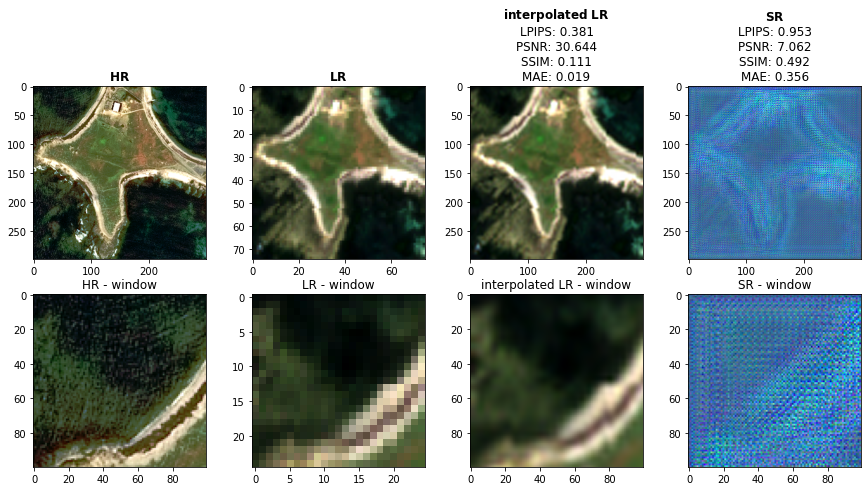

In [9]:
if __name__ == "__main__":
    main()